 ## Here are the tests for the different detectors

In [1]:
# Import necessary dependencies
import cv2
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torch
from PIL import Image

# Import Ikomia API
from ikomia.dataprocess.workflow import Workflow
from ikomia.dataprocess import CImageIO, CInstanceSegmentationIO
from ikomia.core import CWorkflowTaskIO, IODataType

# Import the custom modules
from simple_lama_inpainting import SimpleLama
# from diffusers import StableDiffusionInpaintPipeline
# import transformers

# Import the necessary classes
from detectors import RedCapDetector 
from detectors import YOLODetector
from segmentors import YoloSegmentor
from segmentors import FlorenceSegmentor
from removers import BlurringRemover
from removers import LamaInpaintingRemover


# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
%matplotlib inline

In [3]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

In [11]:
def display_images_in_grid(images):
    """
    Displays 9 images in a 3x3 grid on a single matplotlib canvas.

    Parameters:
    - images: List of 9 images as numpy arrays (in BGR format).
    """
    if len(images) != 9:
        raise ValueError("Exactly 9 images are required.")

    # Create a 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    for i, image in enumerate(images):
        # Convert the image from BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image in the correct subplot
        ax = axes[i // 3, i % 3]
        ax.imshow(image_rgb)
        ax.axis('off')  # Hide the axis for a cleaner look

    plt.tight_layout()
    plt.show()

# Example usage:
# images = [img1, img2, ..., img9]  # List of 9 images as numpy arrays in BGR format
# display_images_in_grid(images)



/Data/mathias.p/ikomia_venv/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/Data/mathias.p/ikomia_venv/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


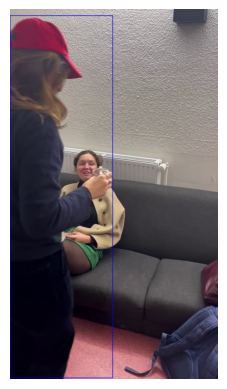

In [4]:
test_image = cv2.imread('/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/data/mathias.p/_test_data/output/IMG_4802_output/debugging/detector/frame_5.jpg')
imshow(test_image)

Frame size is:  (1920, 1080)
Red caps detected: [(3, 45, 373, 310)]
Initializing the tracker... with : (3, 45, 373, 310)
Red Cap Detector Output: [(3, 45, 373, 310)]


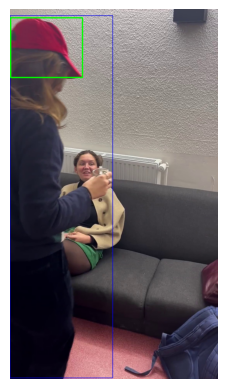

In [5]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""
red_cap_detector = RedCapDetector()

red_cap_boxes = red_cap_detector.detect_and_track(test_image)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = test_image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 5)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    
    imshow(test_image_bis)

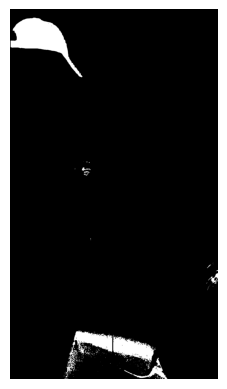

In [44]:
hsv_frame = cv2.cvtColor(test_image, cv2.COLOR_BGR2HSV)

mask2 = cv2.inRange(hsv_frame, (160, 100, 100), (180, 255, 255))
combined_mask = mask2

imshow(combined_mask)

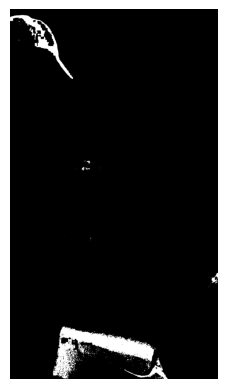

In [10]:
imshow(combined_mask)

In [45]:
contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# display_the_contour
# contour_image = test_image.copy()
# cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)
# imshow(contour_image)
print(len(contours))

327


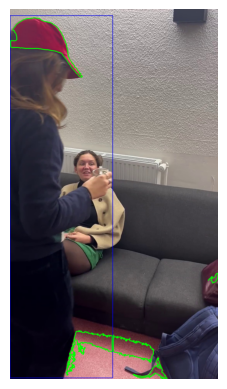

In [46]:
# Adjust min_size dynamically based on frame resolution
height, width = test_image.shape[:2]
min_size = max(10, int((height * width) * 0.0002))
test_image_bis = test_image.copy()

contours_to_keep = []

for contour in contours:
    area = cv2.contourArea(contour)
    if area >= min_size:
        contours_to_keep.append(contour)
        
cv2.drawContours(test_image_bis, contours_to_keep, -1, (0, 255, 0), 3)
        
imshow(test_image_bis)

4
20 50 396 296
aspect_ratio :  1.337837837837838
perimeter 1259.4011427164078
circularity : 0.3155356161172942


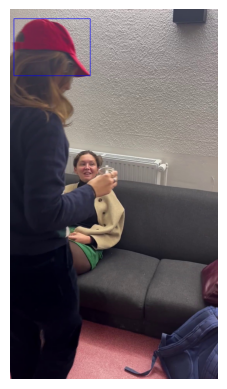

In [38]:
bounding_boxes = []
print(len(contours_to_keep))

for contour in [contours_to_keep[3]]:
    area = cv2.contourArea(contour)
    x, y, w, h = cv2.boundingRect(contour)
    print(x, y, w, h)
    aspect_ratio = w / h
    print("aspect_ratio : ", aspect_ratio)

    # Compute circularity: (4 * π * Area) / (Perimeter^2)
    perimeter = cv2.arcLength(contour, True)
    print("perimeter", perimeter)
    if perimeter == 0:
        continue
    circularity = (4 * np.pi * area) / (perimeter * perimeter)
    print("circularity :", circularity)

    # Add checks: circularity, aspect ratio
    if circularity >= 0.3 and aspect_ratio >= 0.7 and aspect_ratio <= 5:
        bounding_boxes.append((x, y, w, h))
        
test_image_bis = test_image.copy()
for x, y, w, h in bounding_boxes:
    cv2.rectangle(test_image_bis, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
imshow(test_image_bis)

In [ ]:
    def detect(self, frame: np.ndarray, hue_range=(0, 5), alt_hue_range=(170, 180), min_circularity=0.325, ratio=0.0002, min_saturation=100, min_value=100) -> list:
        """
        Detect the region where the red cap is most likely located.
        """
        # Convert the frame from BGR to HSV color space
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask based on hue ranges
        mask1 = cv2.inRange(hsv_frame, (hue_range[0], min_saturation, min_value), (hue_range[1], 255, 255))
        mask2 = cv2.inRange(hsv_frame, (alt_hue_range[0], min_saturation, min_value), (alt_hue_range[1], 255, 255))
        combined_mask = cv2.bitwise_or(mask1, mask2)

        # Find contours in the combined mask
        contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return []

        # Adjust min_size dynamically based on frame resolution
        height, width = frame.shape[:2]
        min_size = max(10, int((height * width) * ratio))

        # Filter contours based on area, aspect ratio, and circularity
        bounding_boxes = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_size:
                continue

            # Get the bounding rectangle for the contour
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / h

            # Compute circularity: (4 * π * Area) / (Perimeter^2)
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue
            circularity = (4 * np.pi * area) / (perimeter * perimeter)

            # Add checks: circularity, aspect ratio
            if circularity >= min_circularity and 0.5 <= aspect_ratio <= 2.0:
                bounding_boxes.append((x, y, w, h))

        return bounding_boxes

Red caps detected: [(1184, 418, 200, 96)]
bbox:  (1184, 418, 200, 96)
Red Cap Detector Output: [(1184, 418, 200, 96)]


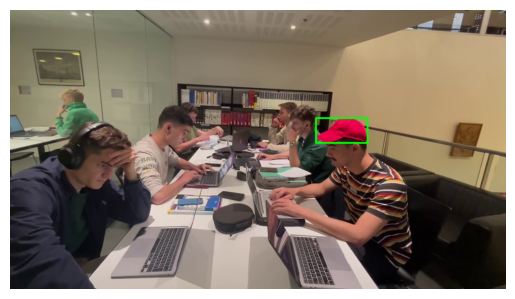

In [5]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""
red_cap_detector = RedCapDetector()

red_cap_boxes = red_cap_detector.detect_and_track(test_image)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = test_image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 5)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    
    imshow(test_image_bis)

In [6]:
detector= YOLODetector()
boxes = detector.detect(test_image)

print("YOLO Detector Output:", boxes)
print("Number of boxes:", len(boxes))
test_copy = test_image.copy()
for box in boxes:
    x, y, w, h = box
    cv2.rectangle(test_copy, (x, y), (x+w, y+h), (0, 255, 0), 5)

imshow(test_copy)

Will run on cpu
Fusing layers... 


/users/eleves-b/2022/mathias.perez/Ikomia/Plugins/Python/infer_yolo_v7/yolov7/utils/torch_utils.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weigh

Workflow Untitled run successfully in 500.141125 ms.
Area: 42245.0, Circularity: 0.5209630636454212, Aspect Ratio: 1.932642487046632
YOLO Detector Output: [(2149, 1306, 1048, 1326)]
Number of boxes: 1


In [7]:
segmentor = YoloSegmentor(device='cuda')

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.18 is currently installed 



0: 640x512 3 persons, 1 laptop, 19.0ms
Speed: 0.7ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)
Workflow Untitled run successfully in 304.999288 ms.


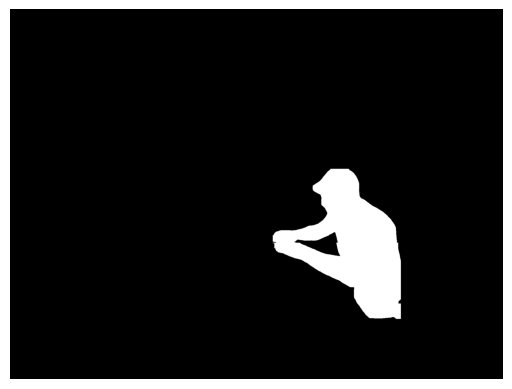

In [10]:
mask1= segmentor.segment(test_image, boxes)

imshow(mask1, cmap='gray')

In [2]:
frame_1 = cv2.imread('_test_data/frame_0.jpg')
frame_2 = cv2.imread('_test_data/frame_1.jpg')
frame_3 = cv2.imread('_test_data/frame_2.jpg')
frame_4 = cv2.imread('_test_data/frame_3.jpg')
frame_5 = cv2.imread('_test_data/frame_4.jpg')
frame_6 = cv2.imread('_test_data/frame_5.jpg')
frame_7 = cv2.imread('_test_data/frame_6.jpg')
frame_8 = cv2.imread('_test_data/frame_7.jpg')
frame_9 = cv2.imread('_test_data/frame_8.jpg')

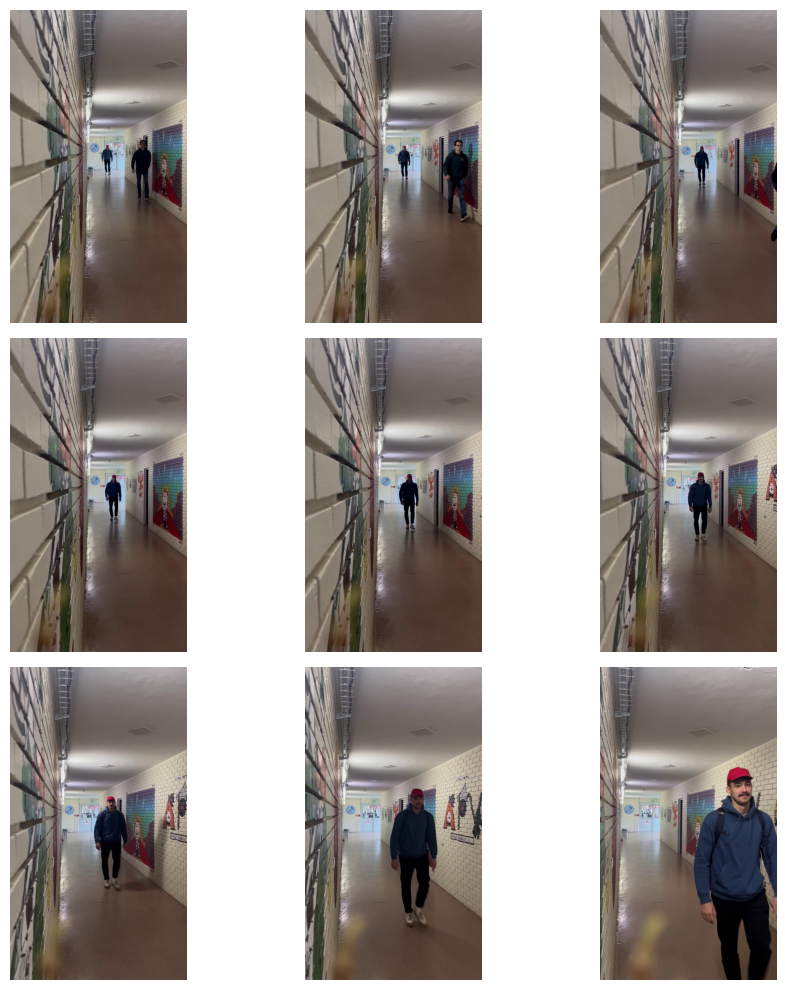

In [13]:
list_of_frames = [frame_1, frame_2, frame_3, frame_4, frame_5, frame_6, frame_7, frame_8, frame_9]
display_images_in_grid(list_of_frames)

In [18]:
detector = YOLODetector(device='cuda')
red_cap_detector = RedCapDetector()

In [19]:
for i, frame in enumerate(list_of_frames):
    print("Analyzing frame :", i)
    print("shape : ",frame.shape)
    red_cap_boxes = red_cap_detector.detect(frame)
    print("Number of red cap boxes:", len(red_cap_boxes))

    boxes = detector.detect(frame)
    print("Number of boxes:", len(boxes))
    

Analyzing frame : 0
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Will run on cuda
Fusing layers... 


/users/eleves-b/2022/mathias.perez/Ikomia/Plugins/Python/infer_yolo_v7/yolov7/utils/torch_utils.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weigh

Workflow Untitled run successfully in 275.647662 ms.
Number of boxes: 0
Analyzing frame : 1
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.732118 ms.
Number of boxes: 0
Analyzing frame : 2
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.479174 ms.
Number of boxes: 0
Analyzing frame : 3
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.486401 ms.
Number of boxes: 0
Analyzing frame : 4
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.76044 ms.
Number of boxes: 0
Analyzing frame : 5
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.745983 ms.
Number of boxes: 0
Analyzing frame : 6
shape :  (1920, 1080, 3)
Number of red cap boxes: 0
Workflow Untitled run successfully in 25.711257 ms.
Number of boxes: 0
Analyzing frame : 7
shape :  (1920, 1080, 3)
Number of red cap boxes: 0

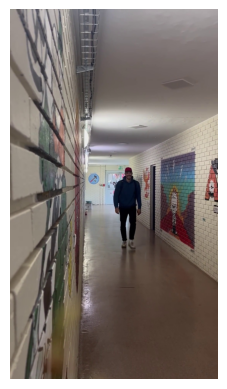

In [24]:
# let's work on frame 6 
frame = frame_6
imshow(frame)

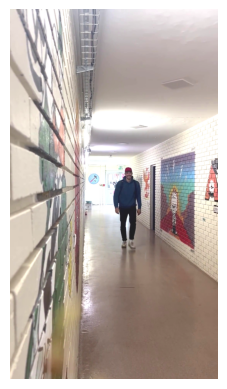

In [28]:
imshow(cv2.convertScaleAbs(frame, alpha=1.3, beta=30))

## Lets play with the detectors parameters

In [8]:
test_image1 = cv2.imread('_test_data/test1.jpg')
test_image2 = cv2.imread('_test_data/test3.jpg')
test_image3 = cv2.imread('_test_data/frame_4.jpg')
test_image4 = cv2.imread('_test_data/frame_5.jpg')
test_image5 = cv2.imread('_test_data/frame_6.jpg')

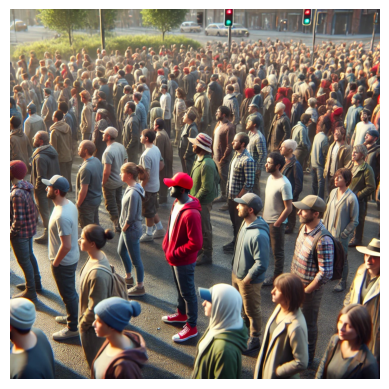

In [14]:
imshow(test_image1)

In [5]:
red_cap_detector = RedCapDetector()

In [ ]:
boxes = red_cap_detector.detect(test_image1)


In [9]:
@interact(min_value = (20, 200, 20), min_saturation = (20, 200, 20))
def imshow_with_yolo(min_value, min_saturation):
    red_cap1 = red_cap_detector.detect(test_image1, min_value=min_value, min_saturation=min_saturation)
    red_cap2 = red_cap_detector.detect(test_image2, min_value=min_value, min_saturation=min_saturation)
    red_cap3 = red_cap_detector.detect(test_image3, min_value=min_value, min_saturation=min_saturation)
    red_cap4 = red_cap_detector.detect(test_image4, min_value=min_value, min_saturation=min_saturation)
    red_cap5 = red_cap_detector.detect(test_image5, min_value=min_value, min_saturation=min_saturation)


    if red_cap1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in red_cap1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 6)
        


    if red_cap2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in red_cap2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 6)

    if red_cap3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in red_cap3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 6)

    if red_cap4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in red_cap4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 6)

    if red_cap5 is not None:
        test_image_bis5 = test_image5.copy()
        for box in red_cap5:
            x, y, w, h = box
            cv2.rectangle(test_image_bis5, (x, y), (x+w, y+h), (0, 255, 0), 6)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0,0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis5, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 5')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')


    plt.show()

interactive(children=(IntSlider(value=100, description='min_value', max=200, min=20, step=20), IntSlider(value…